# Endometrium analysis - clusters visualization

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata
import os
import sys

def MovePlots(plotpattern, subplotdir):
    os.system('mkdir -p '+str(sc.settings.figdir)+'/'+subplotdir)
    os.system('mv '+str(sc.settings.figdir)+'/*'+plotpattern+'** '+str(sc.settings.figdir)+'/'+subplotdir)

sc.settings.verbosity = 1  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.figdir = './figures_stromal/'
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures

sys.executable

scanpy==1.4.4.post1 anndata==0.6.22.post1 umap==0.3.10 numpy==1.17.5 scipy==1.4.1 pandas==0.25.3 scikit-learn==0.22.1 statsmodels==0.10.2 python-igraph==0.7.1 louvain==0.6.1


'/home/jovyan/my-conda-envs/myenvSC/bin/python'

## Load data

In [2]:
adata_original = sc.read('data/endometrium-N2-clean-manifold.h5ad')
adata_original.X.shape

(65191, 26245)

In [3]:
adata_original.obs.head()

,batch,bh_pval,bonf_pval,clinical,day,individual,is_doublet,is_doublet_propagate,leiden,location,n_counts,n_genes,percent_mito,phase,sample,scrublet_cluster_score,scrublet_score,treatment,type,zscore
index,,,,,,,,,,,,,,,,,,,,
4861STDY7309368_AAACCTGAGATCCTGT,0,0.832772,1.0,U,U,A10,False,False,4,ENMY,11092.0,3521,0.026776,S,4861STDY7309368,0.035422,0.028668,C,CBTM,-0.546844
4861STDY7309368_AAACCTGCACCTCGGA,0,0.809091,1.0,U,U,A10,False,False,2,ENMY,8831.0,2832,0.030234,S,4861STDY7309368,0.059091,0.063830,C,CBTM,0.427611
4861STDY7309368_AAACCTGTCAACACTG,0,0.809091,1.0,U,U,A10,False,False,4,ENMY,4803.0,1834,0.013533,S,4861STDY7309368,0.068966,0.059091,C,CBTM,0.834157
4861STDY7309368_AAACCTGTCTAACGGT,0,0.809091,1.0,U,U,A10,False,False,0,ENMY,7717.0,2611,0.020345,S,4861STDY7309368,0.059091,0.054705,C,CBTM,0.427611
4861STDY7309368_AAACGGGAGCTCCTTC,0,0.856750,1.0,U,U,A10,False,False,6,ENMY,5644.0,2015,0.021616,S,4861STDY7309368,0.022817,0.020690,C,CBTM,-1.065830


In [4]:
set(adata_original.obs.individual)

{'A10', 'A13', 'A16', 'A30', 'Endo8625698', 'Endo8712024', 'Endo8715415'}

In [5]:
adata_original.obs.at[ adata_original.obs[ 'individual'] == 'A10', 'phase']  = 'P'
adata_original.obs.at[ adata_original.obs[ 'individual'] == 'A16', 'phase']  = 'P'

## Reset object

In [6]:
adata_original = adata_original[[ i in ['0', '6', '2'] for i in adata_original.obs['leiden'] ]]

In [7]:
adata_original.obs['leiden_K'] = adata_original.obs['leiden']
adata_original.obs['cycle_phase'] = adata_original.obs['phase']
adata = anndata.AnnData(X=adata_original.raw.X, var=adata_original.raw.var, obs=adata_original.obs, asview=False)

Trying to set attribute `.obs` of view, making a copy.


## Preprocess the data again

#### Filter non-expressed genes

In [8]:
sc.pp.filter_genes(adata, min_cells=5)

#### Normalize per cell

In [9]:
adata.raw = sc.pp.log1p(adata, copy=True)
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

#### HVGs
These are going to be definetively different from the global annlysis. It is key to redefine these.

In [10]:
# Filter HVGs
sc.pp.log1p(adata)
# sc.pp.highly_variable_genes(adata, min_mean=0.0125, min_disp=0.5)
sc.pp.highly_variable_genes(adata, min_mean=0.0125,  max_mean=3, min_disp=0.25)
# sc.pp.highly_variable_genes(adata, n_top_genes=2000)
highly_variable_genes = adata.var["highly_variable"]
adata = adata[:, highly_variable_genes]

In [11]:
adata.X.shape

(22004, 3719)

#### Scale and regress out cell cycle genes

In [12]:
# Scale
sc.pp.scale(adata, max_value=10)

/home/jovyan/my-conda-envs/myenvSC/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:869: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [13]:
# Regress out cell cycle genes
cell_cycle_genes = [x.strip() for x in open(file='/home/jovyan/farm/gsea/raw/seurat_cellcycle/regev_lab_cell_cycle_genes.txt')]
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
s_genes = [x for x in s_genes if x in adata.var_names]
g2m_genes = [x for x in g2m_genes if x in adata.var_names]
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)
# sc.pp.regress_out(adata, ['S_score', 'G2M_score'])

## PCA

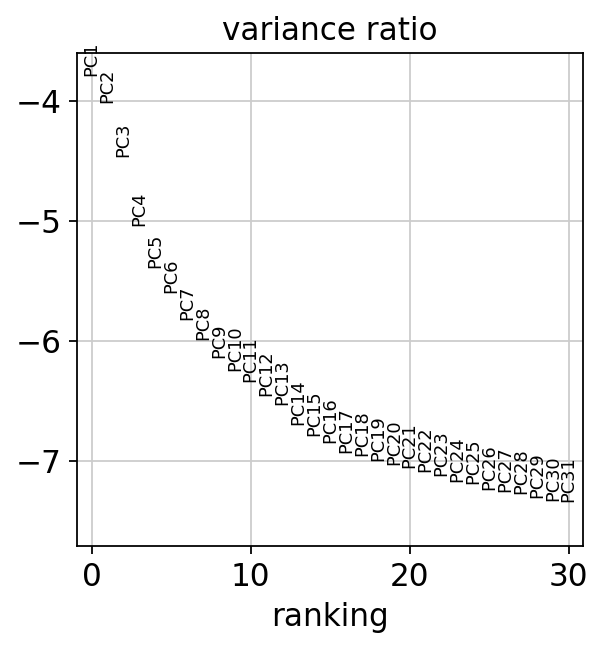

In [14]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True, save='.pdf')

## Batch correction using HARMONY

In [15]:
# Extract PCA matrix and batch array
n_pcs = 8#5
pca = adata.obsm['X_pca'][:, 0:(n_pcs)]
batch = adata.obs['individual']

In [16]:
# Batch-correct the PCA using HARMONY method
%load_ext rpy2.ipython

In [17]:
%%R -i pca -i batch -o hem

library(harmony)
library(magrittr)
set.seed(1000)
hem <- HarmonyMatrix(pca, batch, theta=0, do_pca=FALSE, verbose = FALSE)
hem = data.frame(hem)

R[write to console]: Loading required package: Rcpp



In [18]:
# Add harmony values to the anndata object
adata.obsm['X_pca'] = hem.values

In [19]:
sc.pp.neighbors(adata, n_pcs = n_pcs, random_state=1)

/home/jovyan/my-conda-envs/myenvSC/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../my-conda-envs/myenvSC/lib/python3.7/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/home/jovyan/my-conda-envs/myenvSC/lib/python3.7/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../my-conda-envs/myenvSC/l

In [20]:
# Visualize
sc.tl.umap(adata)

... storing 'phase' as categorical


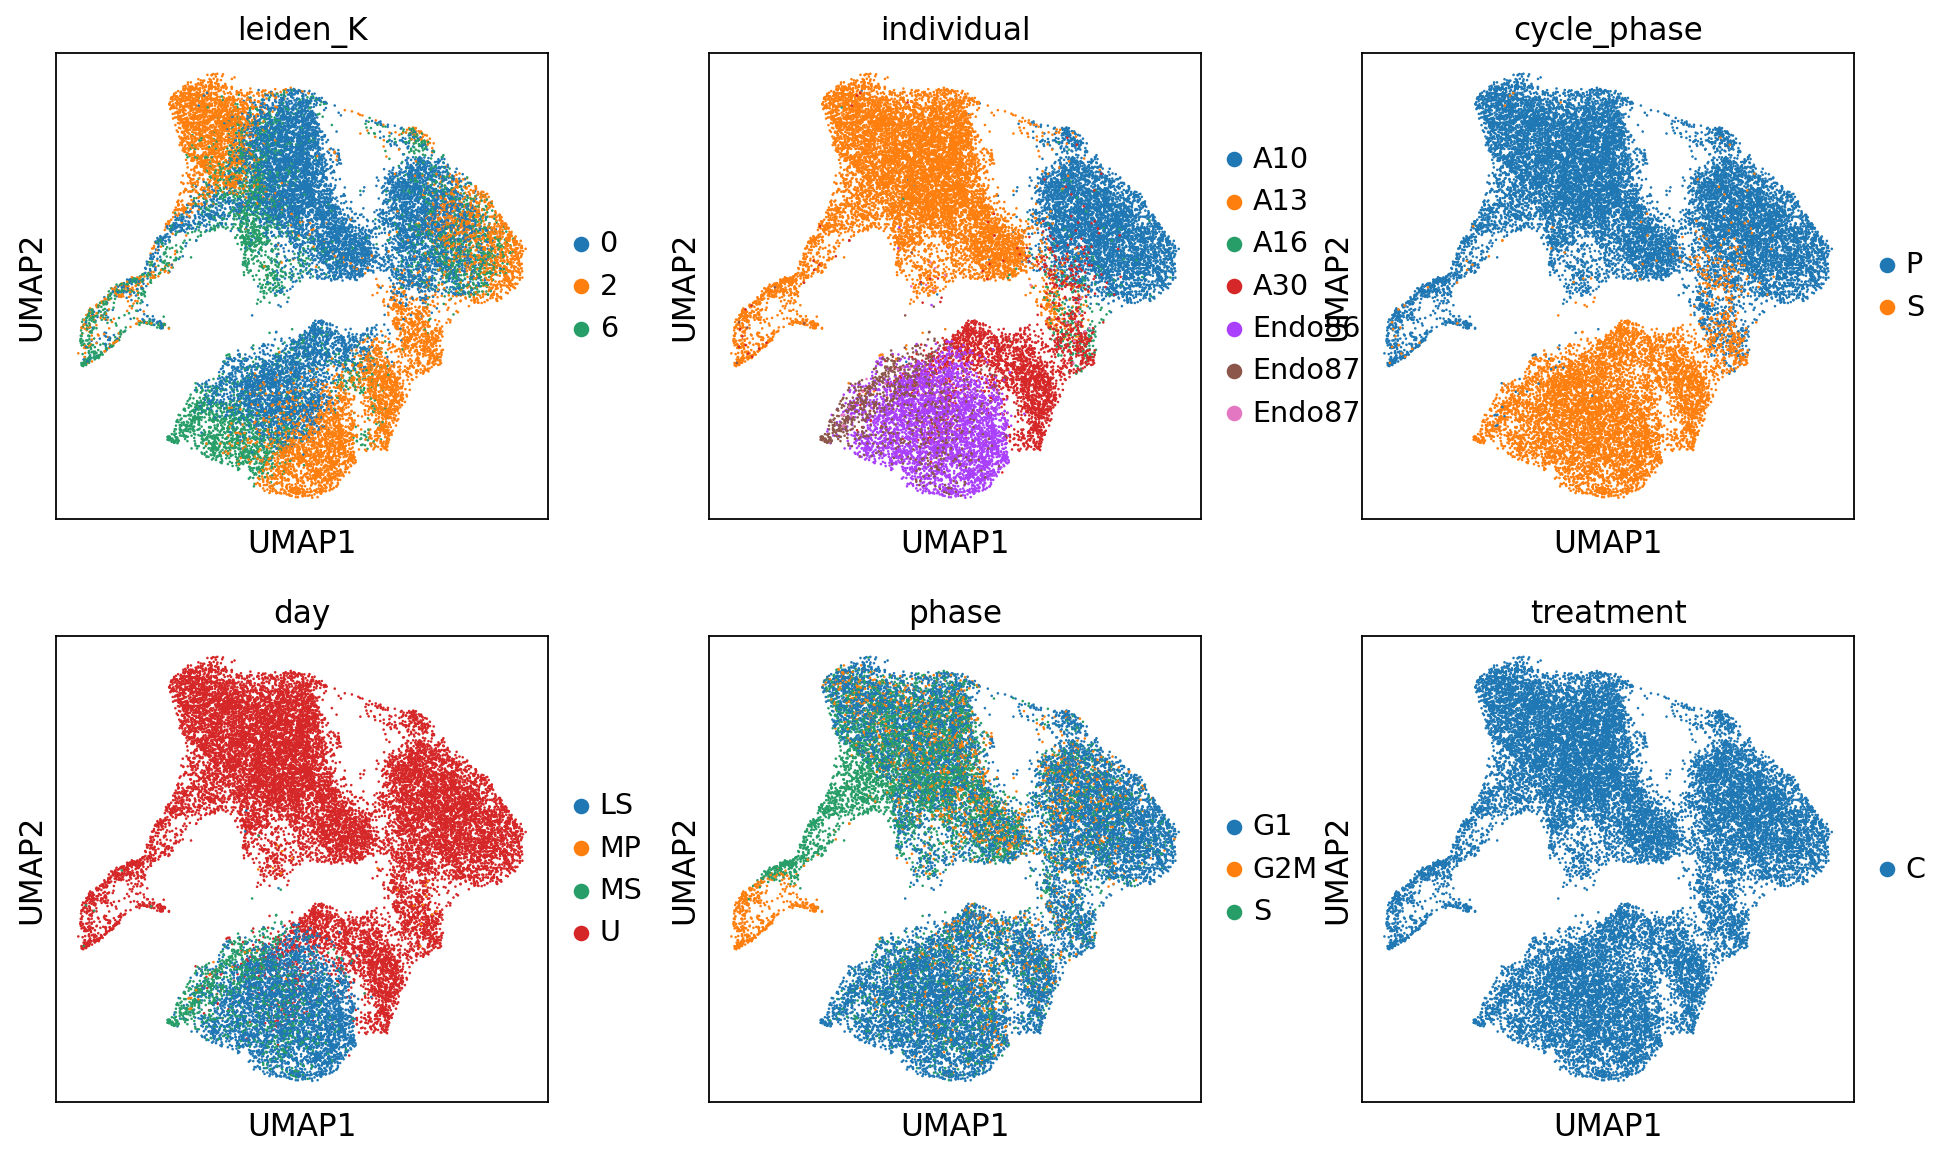

In [21]:
sc.pl.umap(adata, color=['leiden_K', 'individual','cycle_phase', 'day', 'phase', 'treatment'], save='.pdf', ncols = 3)

## Identify sub-clusters

In [22]:
sc.tl.leiden(adata, resolution=0.1)

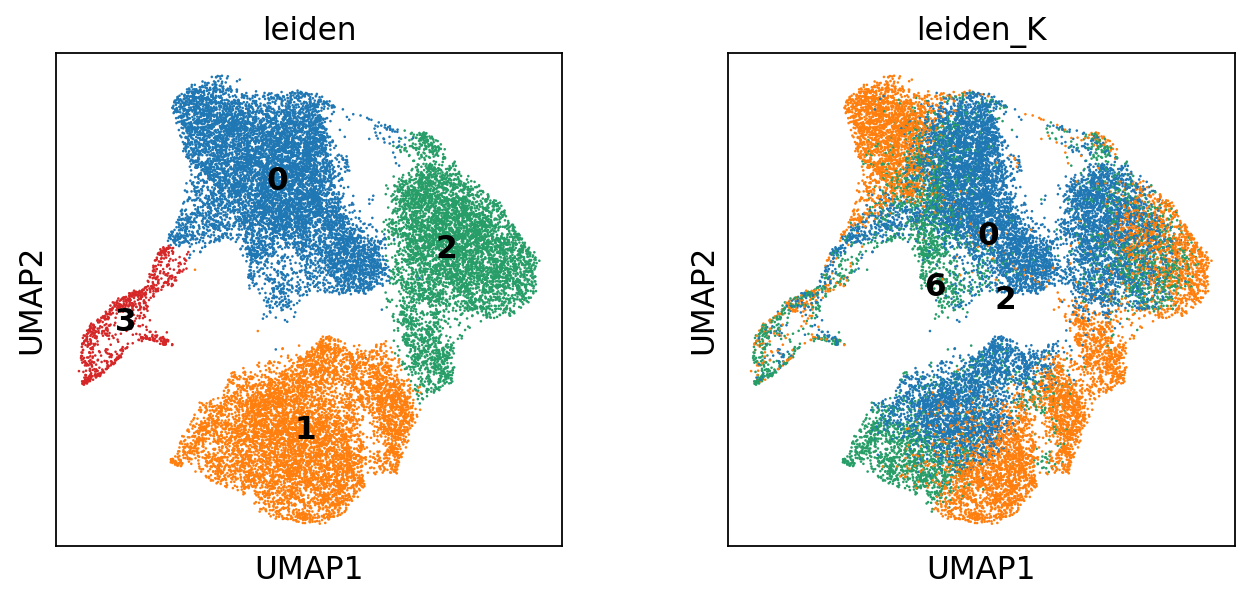

In [23]:
sc.pl.umap(adata, color=['leiden', 'leiden_K'],legend_loc='on data',save='_clustering_clusnumbers.pdf')

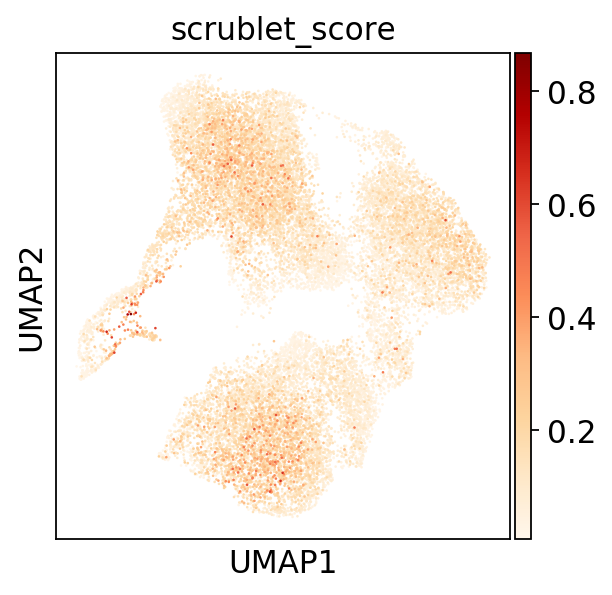

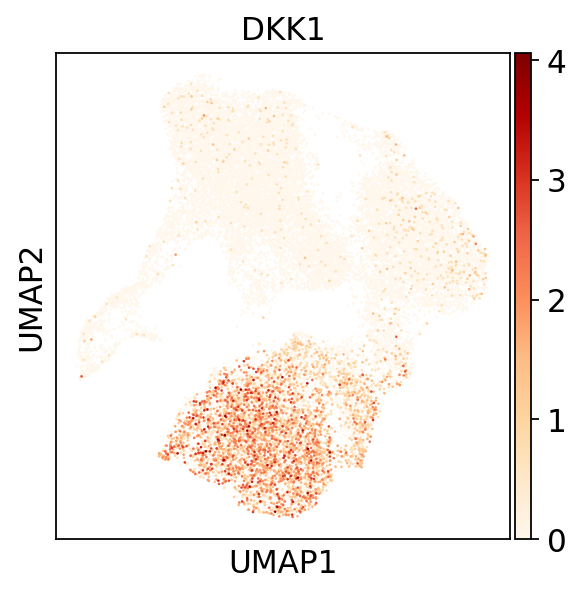

In [24]:
sc.pl.umap(adata, color=["scrublet_score"], save='-markers_scrublet_score.pdf',color_map='OrRd') # FEMALE
sc.pl.umap(adata, color=["DKK1"], color_map='OrRd') # FEMALE

## Save

In [51]:
os.system('rm data/endometrium-M1-stromal.h5ad')
adata.write('data/endometrium-M1-stromal.h5ad')